[YT vídeo link](https://www.youtube.com/watch?v=fzX55uQs4Sg)

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, ShuffleSplit, validation_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [11]:
np.random.seed(306)

Sera usada a ShuffleSplit como estratégia de validação cruzada.

In [12]:
shuffle_split_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

In [13]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)
com_train_features, test_features, com_train_labels, test_labels = train_test_split(features, labels, random_state=42)

In [14]:
train_features, dev_features, train_labels, dev_labels = train_test_split(com_train_features, com_train_labels, random_state=42)

In [15]:
sgd = SGDRegressor(random_state=42)
sgd.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd.predict(dev_features))
print("Mean absolute error on Training set: ", train_mae)
print("Mean absolute error on development set: ", dev_mae)

Mean absolute error on Training set:  309190327803747.2
Mean absolute error on development set:  311959782899622.1


Adc o escalonamento de features: 

In [16]:
sgd_pipeline = Pipeline([("features_scaling", StandardScaler()),
                        ("sgd", SGDRegressor())])
sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print("Mean absolute error on Training set: ", train_mae)
print("Mean absolute error on development set: ", dev_mae)

Mean absolute error on Training set:  0.7120658904697419
Mean absolute error on development set:  0.9804229242073539


# Fazendo o SGD passo a passo

Text(0.5, 1.0, 'Learning curve: eta0=0.0100')

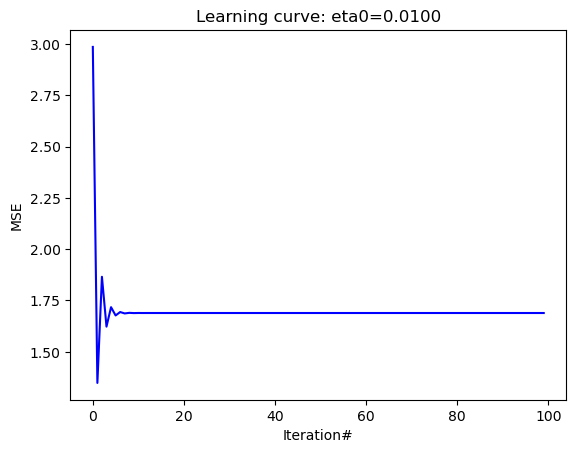

In [17]:
eta0 = 1e-2
sgd_pipeline = Pipeline([("features_scaling", StandardScaler()),
                        ("SGD", SGDRegressor(max_iter=1, tol=None, #-np.infty,
                                            warm_start=True,
                                            random_state = 42))])

loss = []
for epoch in range(100):
    sgd_pipeline.fit(train_features, train_labels)
    loss.append(mean_squared_error(train_labels,
                                    sgd_pipeline.predict(train_features)))

plt.plot(np.arange(len(loss)), loss, '-b')
plt.xlabel('Iteration#')
plt.ylabel('MSE')
plt.title(f'Learning curve: eta0={eta0:.4f}')

Text(0.5, 1.0, 'Learning curve: eta0=0.0010')

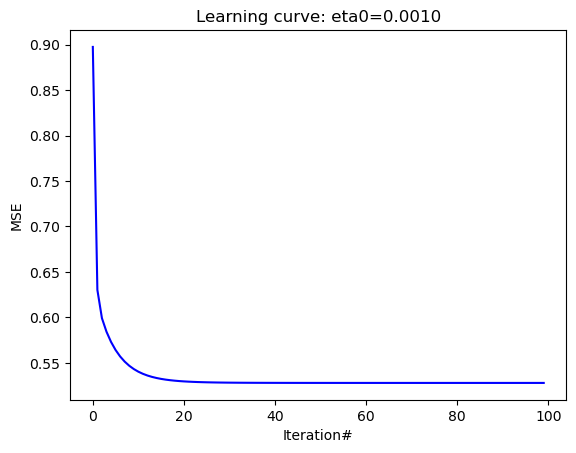

In [18]:
eta0 = 1e-3
sgd_pipeline = Pipeline([("features_scaling", StandardScaler()),
                        ("SGD", SGDRegressor(max_iter=1, tol=None, #-np.infty,
                                            warm_start=True, eta0 = eta0,
                                            random_state = 42))])

loss = []
for epoch in range(100):
    sgd_pipeline.fit(train_features, train_labels)
    loss.append(mean_squared_error(train_labels,
                                    sgd_pipeline.predict(train_features)))

plt.plot(np.arange(len(loss)), loss, '-b')
plt.xlabel('Iteration#')
plt.ylabel('MSE')
plt.title(f'Learning curve: eta0={eta0:.4f}')

In [20]:
print("# Iteration before reaching convergence criteria:",
      sgd_pipeline[-1].n_iter_)
print("# weight updates:", sgd_pipeline[-1].t_)

# Iteration before reaching convergence criteria: 1
# weight updates: 11611.0


In [21]:
train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print("MAE on training set:", train_mae)
print("MAE on development set:", dev_mae)

MAE on training set: 0.5333732983042573
MAE on development set: 0.5190150280908042


# Fixing learning rate through validation curves
* Step 1: Provide the list of values to be tried for a hyper-parameter.
* Step 2: Instantiate an object of *validation_curve* with estimator, training features and label. Set *scoring* parameter to relevant score.
* Step 3: Convert scores to error.
* Step 4: Plot validation curve with the value of hyper-parameter on x-axis and error on the y-axis.
* Step 5: Fix the hyper-parameter value where the test error is the least

In [34]:
%%time
eta0 = [1e-5, 1e-4, 1e-3, 1e-2]
train_scores, test_scores = validation_curve(sgd_pipeline, com_train_features, com_train_labels, param_name = "SGD__eta0", param_range = eta0, cv = shuffle_split_cv, scoring = "neg_mean_squared_error", n_jobs = 2)
train_erros, test_errors = -train_scores, -test_scores

CPU times: total: 219 ms
Wall time: 13.5 s


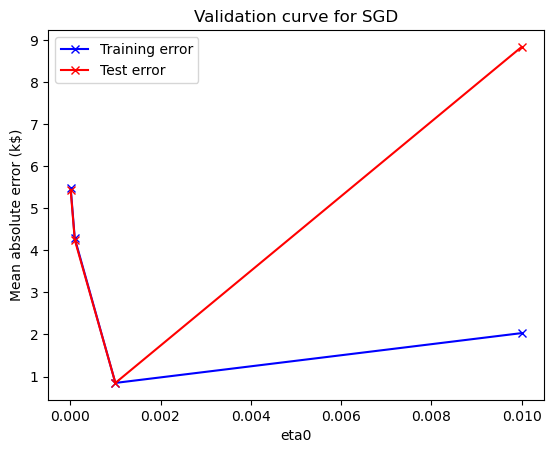

In [35]:
train_erros, test_errors = -train_scores, -test_scores
plt.plot(eta0, train_erros.mean(axis = 1), "b-x", label = "Training error")
plt.plot(eta0, test_errors.mean(axis = 1), "r-x", label = "Test error")
plt.legend()

plt.xlabel("eta0")
plt.ylabel("Mean absolute error (k$)")
_ = plt.title("Validation curve for SGD")

For eta0 = 1e-3, the test error is the least and hence we select that value as the value for *eta0*.

Next we also plot standard deviation in erros.

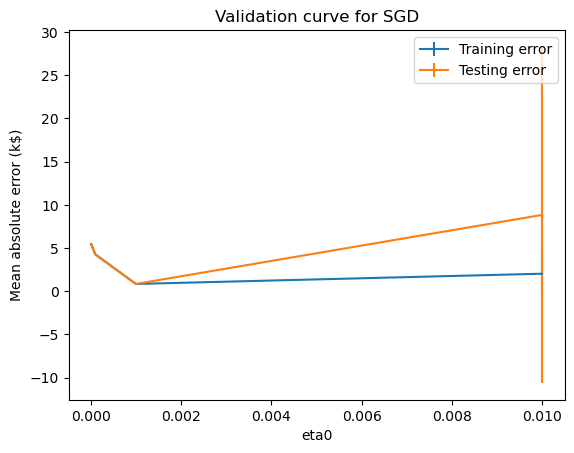

In [36]:
train_errors, test_errors = -train_scores, -test_scores
plt.errorbar(eta0, train_errors.mean(axis=1),
                yerr = train_erros.std(axis=1), label = "Training error")
plt.errorbar(eta0, test_errors.mean(axis = 1),
             yerr=test_errors.std(axis = 1), label = "Testing error")
plt.legend()

plt.xlabel("eta0")
plt.ylabel("Mean absolute error (k$)")
_ = plt.title("Validation curve for SGD")

# SGDRegressor

In [39]:
# normalizando os dados
sgd_pipeline = Pipeline([("Feature_scaling", StandardScaler()),
                        ("sgd", SGDRegressor(max_iter=500,
                        early_stopping = True,
                        eta0 = 1e-3,
                        tol = 1e-3,
                        validation_fraction = 0.2,
                        n_iter_no_change = 5,
                        average = 10,
                        random_state = 42))])

#treinando modelo
sgd_pipeline.fit(train_features, train_labels)

# medindo o modelo
train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print("MAE on Training set: ", train_mae)
print("MAE on development set: ", dev_mae)

MAE on Training set:  0.5433287489797833
MAE on development set:  0.5345612073911921


In [40]:
print("Number of SGD iterations: ", sgd_pipeline[-1].n_iter_)
print("Number of weight updates: ", sgd_pipeline[-1].t_)

Number of SGD iterations:  35
Number of weight updates:  406351.0
